<a href="https://colab.research.google.com/github/guaaaaa/NST/blob/master/Neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import
import torch
import torch.nn as nn
import torch.optim as optimization

import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import save_image

from tqdm.notebook import tqdm
from PIL import Image

import matplotlib.pyplot as plt

import os
import requests
from pathlib import Path

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Define content loss functions
def get_content_loss(G, C):
  return torch.mean((G - C)**2)


# Test
x = torch.tensor([[1, 2], [3, 4]], dtype=torch.float)
y = torch.tensor([[5, 6], [7, 8]], dtype=torch.float)

#print(content_loss(x, y))

In [ ]:
# Define style loss function
def gram_matrix(x, h, w, n_c):
  x = x.reshape((n_c, w * h))
  G = torch.mm(x, x.T)

  # Output shows the correlation between every two channels (Shape = (n_c * n_c))
  return G

# Test
print(gram_matrix(x, 2, 2, 1))

def get_style_loss(S, G):
  # S and G should be the same size
  _, n_c, h, w = G.shape
  G_g = gram_matrix(G, h, w, n_c)
  G_s = gram_matrix(S, h, w, n_c)
  return torch.mean((G - S) ** 2, dtype=torch.float) / (n_c * h * w)


tensor([[30.]])


In [ ]:
# Model setup
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.vgg = models.vgg19(pretrained=True).features
    self.selected_layers = ['0', '5', '10', '19', '28']

  def forward(self, x):
    features = []

    # Forward propagation and save the activations from selected layers
    for layer_num, layer in self.vgg._modules.items():
      x = layer(x)
      if layer_num in self.selected_layers:
        features.append(x)

    return features

model = Model().to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Input image proccessing
img_size = 512 if torch.cuda.is_available() else 128

transformer = transforms.Compose([
  transforms.Resize((img_size, img_size)),
  transforms.ToTensor(),
  # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

alpha = 1
beta = 0.3

In [ ]:
# Input images
data_path = Path('data')
data_path.mkdir(exist_ok=True)
content_path = data_path / 'content.jpg'
style_path = data_path / 'style.jpg'
if not content_path.is_file():
  with open(content_path, 'wb') as f:
    request = requests.get('https://www.roadaffair.com/wp-content/uploads/2017/12/banff-national-park-canada-shutterstock_309219305.jpg')
    print('Downloading content image...')
    f.write(request.content)
if not style_path.is_file():
  with open(style_path, 'wb') as f:
    request = requests.get('https://i.etsystatic.com/17358183/r/il/734167/4000363531/il_570xN.4000363531_t74d.jpg')
    print('Downloading style image...')
    f.write(request.content)

In [ ]:
# Transforming images
content_img = Image.open(content_path).convert('RGB')
style_img = Image.open(style_path).convert('RGB')

content = transformer(content_img).unsqueeze(0).to(device).type(torch.float)
style = transformer(style_img).unsqueeze(0).to(device).type(torch.float)

target_img = torch.rand(tuple(content.shape), device=device).requires_grad_(True)

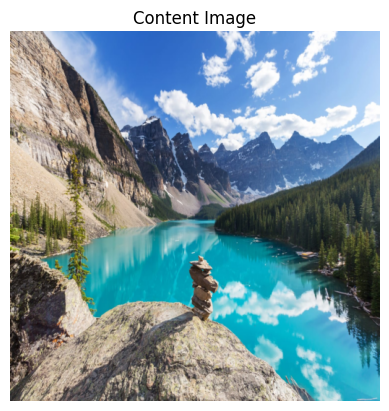

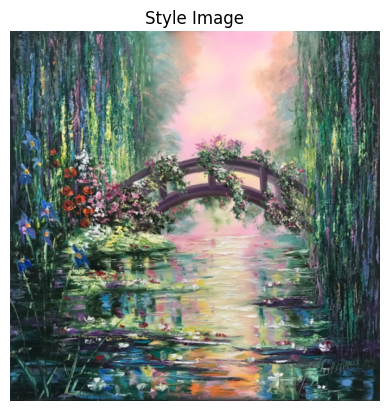

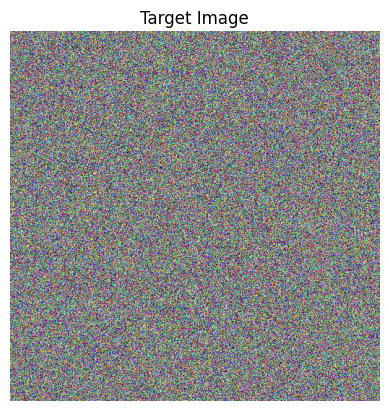

In [ ]:
# Visualize
plt.imshow(content.squeeze(0).permute(1, 2, 0).cpu())
plt.axis(False)
plt.title("Content Image")
plt.show()
plt.imshow(style.squeeze(0).permute(1, 2, 0).cpu())
plt.title("Style Image")
plt.axis(False)
plt.show()
plt.imshow(target_img.squeeze(0).permute(1, 2, 0).cpu().detach())
plt.title("Target Image")
plt.axis(False)
plt.show()

In [ ]:
# Define optimizer
optimizer = optimization.Adam([target_img], lr=0.1)

In [ ]:
# Train the target image
for epoch in tqdm(range(1000)):
  target_img = target_img.to(device)
  content = content.to(device)
  style = style.to(device)

  target_features = model(target_img)
  content_features = model(content)
  style_features = model(style)

    #initiate the losses
  style_loss = 0
  content_loss = 0

  for target_a, content_a, style_a in zip(target_features, content_features, style_features):
    content_loss += get_content_loss(target_a, content_a)
    style_loss += get_style_loss(target_a, style_a)

  #calculate the total loss according to the original paper
  loss = torch.Tensor(alpha*content_loss+beta*style_loss)


  #set parameters to zero
  optimizer.zero_grad()
  #compute the gradient
  loss.backward()
  #update parameters
  optimizer.step()


  0%|          | 0/1000 [00:00<?, ?it/s]

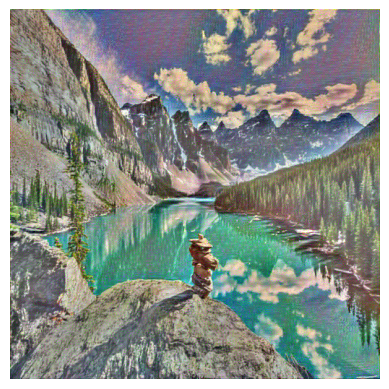

In [ ]:
target_img = target_img.cpu().detach()
plt.imshow(target_img.squeeze(0).permute(1, 2, 0))
plt.axis(False)
plt.show()